In [1]:
from torch import Generator, use_deterministic_algorithms, tensor
from functools import partial
from matplotlib.pyplot import plot

from pathlib import Path
from karpathy_series.makemore.data import read_data
from karpathy_series.makemore.encoding.character import CharacterEncoder, CharacterSet, StringEncoder
from karpathy_series.makemore.training.data import TrainingSequencer
from karpathy_series.makemore.training.learning import Learner
from karpathy_series.makemore.models.generation import NGramNetGenerator
from karpathy_series.makemore.models.mlp import MPLNetComponents
from karpathy_series.makemore.bigrams import NGram

%matplotlib inline
use_deterministic_algorithms(True)
rand_generator = Generator()
seed = 2147483647

def create_generator():
    return rand_generator.manual_seed(seed)

In [2]:
data_path = Path("../../data/names.txt")
words = read_data(data_path)
char_set = CharacterSet.from_words(words)
char_encoder = CharacterEncoder.from_charset(char_set)
string_encoder = StringEncoder(char_encoder)

context_size = 4
n_gram_gen = partial(NGram.generate, context_size, char_set.pad) 
ts = TrainingSequencer(string_encoder, char_encoder, n_gram_gen)

embedding_dims = 10
hidden_dims = 200

In [3]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xis_d, yis_d = ts.training_set(words[n1:n2])
xis_v, yis_v = ts.training_set(words[n2:])
    
learning_sequence = ts.training_sequence(words[:n1], 32, True)

In [4]:
g = rand_generator.manual_seed(seed)
mpl_net = MPLNetComponents.init(4, char_encoder.size, embedding_dims, context_size, hidden_dims, g)
generator = NGramNetGenerator(char_set, string_encoder, char_encoder, mpl_net)
losses = []

In [5]:
print(sum(p.size() for p in mpl_net.layers), "parameters")
print("Layers:")
for k, p in enumerate(mpl_net.layers):
    print(k, p.describe())

134497 parameters
Layers:
0 Embedding [27, 10]
1 Linear [40, 200] with bias
2 Functional
3 Linear [200, 200] with bias
4 Functional
5 Linear [200, 200] with bias
6 Functional
7 Linear [200, 200] with bias
8 Functional
9 Linear [200, 27] with bias


In [6]:
learner = Learner(mpl_net, 0.1)
losses += learner(learning_sequence, epochs=50, report_epochs=10)

Epoch 10 is finished with loss = 1.9937138557434082
Epoch 20 is finished with loss = 2.0006587505340576
Epoch 30 is finished with loss = 1.7715468406677246
Epoch 40 is finished with loss = 1.8840248584747314
Epoch 50 is finished with loss = 1.8863272666931152


In [7]:
print(mpl_net.run(xis_v, yis_v))

tensor(2.0408, grad_fn=<NllLossBackward0>)


In [8]:
for k in range(20):
    print(generator())

kailitha
henry
cateto
nicolas
raylia
hiya
tono
eyvani
zephine
denis
liah
hanett
kyron
demyah
eliannata
arter
remini
laury
kamryn
zhara


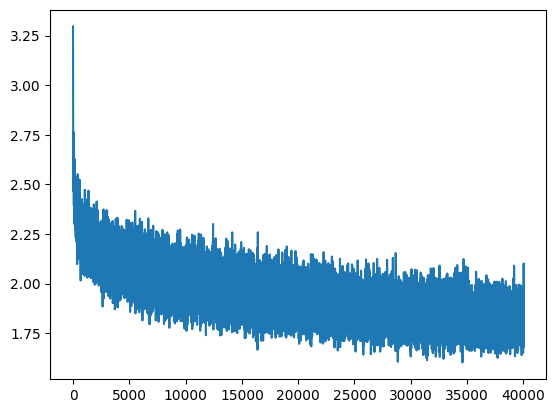

In [9]:
plot(tensor(losses))